In [1]:
# imports
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
print('Matplotlib version: ', mpl.__version__)
print(plt.style.available)
mpl.style.use(['ggplot'])

Matplotlib version:  3.0.2
['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [3]:
with open('../data/subject.pkl', 'rb') as input:
    subjects =  pickle.load(input)
# convert subjects list to dict
subjects_dict = {s.number : s for s in subjects}

In [4]:
# get list of patient id and corresponding available days
id_days = ""
for s in subjects:
    id_days += ("{:<10}".format(s.number) + '\n' + ' '.join(s.motor_data_days.keys()) + '\n')
with open('../record/id_days.txt', 'w') as f:
    f.write(id_days)

In [18]:
# sleep pattern
dfs = [s.motor_data_df for s in subjects]
full_df = pd.concat(dfs, axis=0)
full_timestamps = ["{:02d}:{:02d}:00".format(hour, minute) for hour in range(24) for minute in range(60)]
# sleep: 11pm - 7:59am
sleep_timestamps = ["{:02d}:{:02d}:00".format(hour, minute) for hour in list(range(23, 24)) + list(range(0, 8)) for minute in range(60)]
non_sleep_timestamps = list(set(full_timestamps) - set(sleep_timestamps))
full_df = full_df.set_index('timestamp')
sleep_df = full_df.loc[sleep_timestamps, :]
non_sleep_df = full_df.loc[non_sleep_timestamps, :]
assert (len(sleep_df) + len(non_sleep_df)) == len(full_df)
mean_sleep_activity = sleep_df['activity'].mean()
mean_non_sleep_activity = non_sleep_df['acptivity'].mean()

print('mean_sleep_activity', mean_sleep_activity)
print('mean_non_sleep_activity', mean_non_sleep_activity)

KeyError: 'acptivity'

In [5]:
# observe general trends for individual subject in the span of one day, activity level = minute
def plot_daily_activity(patient_id, date):
    activity_df = subjects_dict[patient_id].motor_data_days.get(date)
    #activity_df.set_index('timestamp', inplace=True)
    activity_df.plot(kind='line', x='timestamp', y='activity', figsize=(20, 6), title='Full Day Activity', legend=False)
    #plt.savefig('../record/plots/individual/{}-{}.jpeg'.format(patient_id, date))
    # too compact, separate into two halves
    midpoint = len(activity_df) // 2  # round down
    first_half = activity_df[:midpoint] 
    second_half = activity_df[midpoint:]
    assert len(first_half) + len(second_half) == len(activity_df)
    fig = plt.figure()
    ax0 = fig.add_subplot(1, 2, 1) 
    ax1 = fig.add_subplot(1, 2, 2)
    
    first_half.plot(kind='line', x='timestamp', y='activity', figsize=(20,6), title='1st Half Activity', legend=False, ax=ax0)
    second_half.plot(kind='line', x='timestamp', y='activity', figsize=(20,6), title='2nd Half Activity', legend=False, ax=ax1)
    activity_df.reset_index(inplace=True)
    

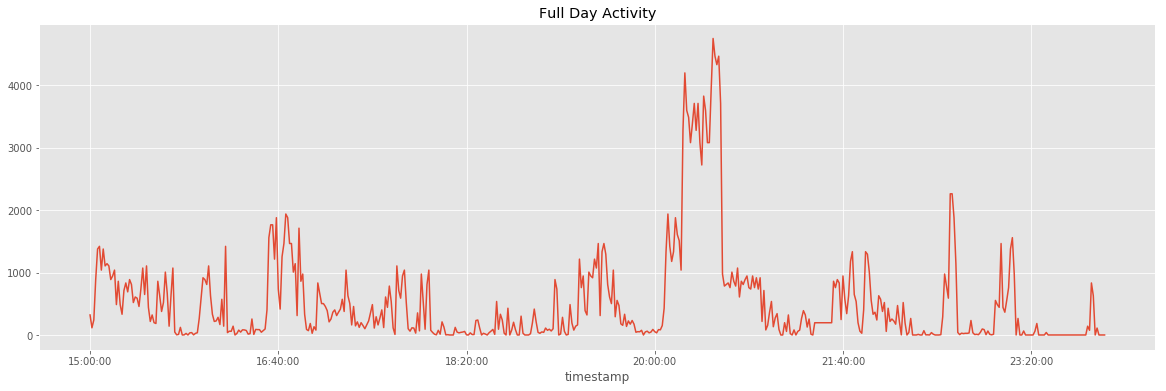

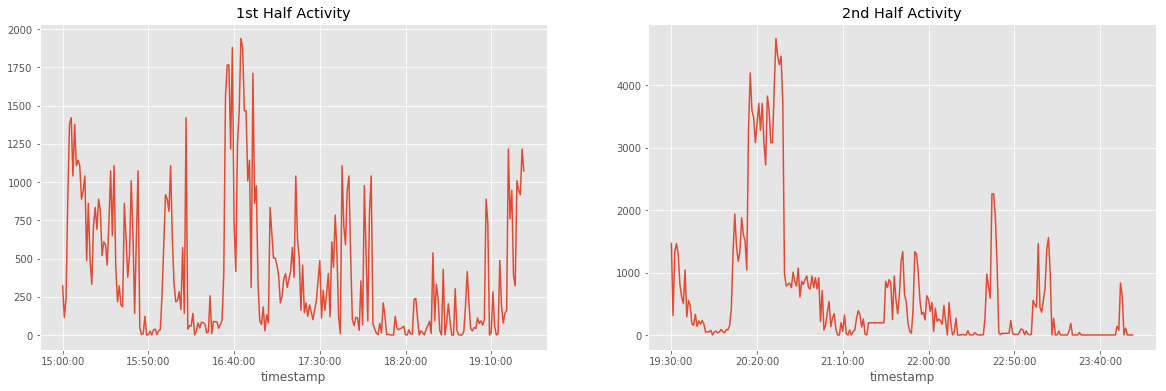

In [25]:
plot_daily_activity('control_31', '2003-03-18')

In [6]:
# compare general trends between two subjects in the span of one day, activity_level = minute
def plot_compare(subject_1, subject_1_date, subject_2, subject_2_date, plot_number=4):
    subject_1_df = subjects_dict[subject_1].motor_data_days.get(subject_1_date)
    subject_2_df = subjects_dict[subject_2].motor_data_days.get(subject_2_date)
    # rename column names
    subject_1_df = subject_1_df.rename(columns={'activity':'{} activity'.format(subject_1)}).set_index('timestamp')
    subject_2_df = subject_2_df.rename(columns={'activity':'{} activity'.format(subject_2)}).set_index('timestamp')
    # may have different time range, only plot intersection timestamp
    intersection_timestamp = list(set(subject_1_df.index).intersection(set(subject_2_df.index)))
    subject_1_df = subject_1_df.loc[intersection_timestamp, :]
    subject_2_df = subject_2_df.loc[intersection_timestamp, :]
    plot_df = pd.concat([subject_1_df, subject_2_df], axis=1) 
    split_point = len(plot_df) // plot_number
    split_df = [plot_df[i * split_point : (i + 1) * split_point] for i in range(plot_number)]
    #plot_df.plot(kind='line', figsize=(20, 6)) # too cramped
    #plt.legend(loc='upper right')
    # first_half_df.plot(kind='line', figsize=(8, 6), alpha=0.8)
    # second_half_df.plot(kind='line', figsize=(8, 6))
    # split into 4 parts, fit into one figure
    fig = plt.figure(figsize=(45, 10))
    axes = [fig.add_subplot(2, 2, i+1) for i in range(plot_number)]
    for i, df in enumerate(split_df):
        df.plot(kind='line', figsize=(20,9), ax=axes[i], xlabel='Timestamp', ylabel='Activity', alpha=0.9)
        axes[i].legend(loc='upper left')

        
    

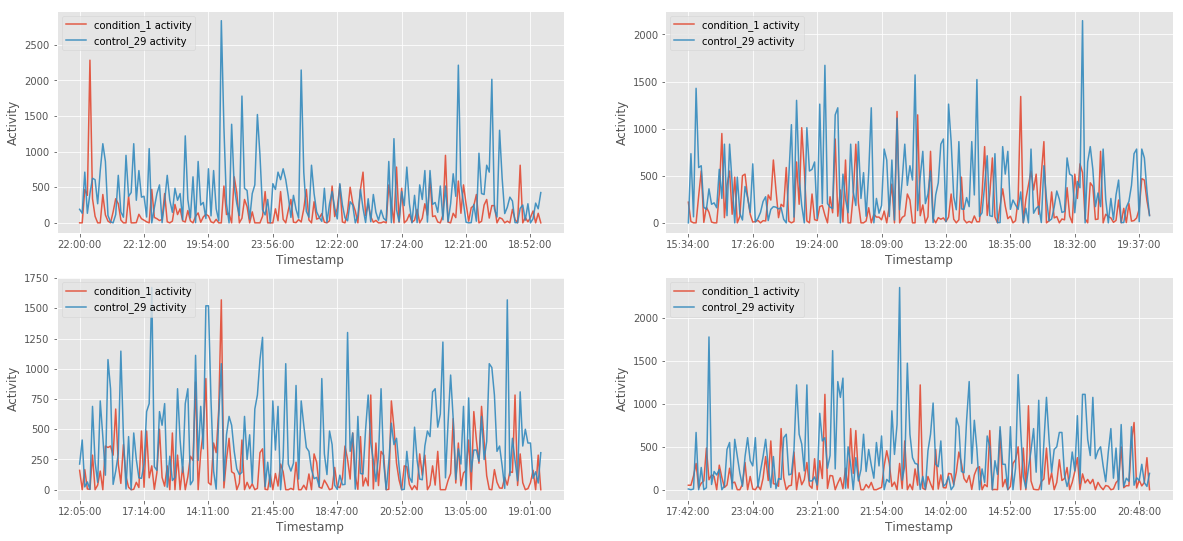

In [7]:
plot_compare('condition_1', '2003-05-07', 'control_29', '2006-01-15')

In [27]:
# trends in individuals' min activity levels over the span of multiple days 
def plot_multiday_activity(subject):
    subject_df = subjects_dict[subject].motor_data_df
    # compute activity mean by day
    daily_mean_df = subject_df.groupby('date')['activity'].mean()
    daily_mean_df.plot(kind='line', figsize=(20,6), 
                       ylabel='mean activity level per minute', title='{} Daily Mean Acitivity'.format(subject))
    

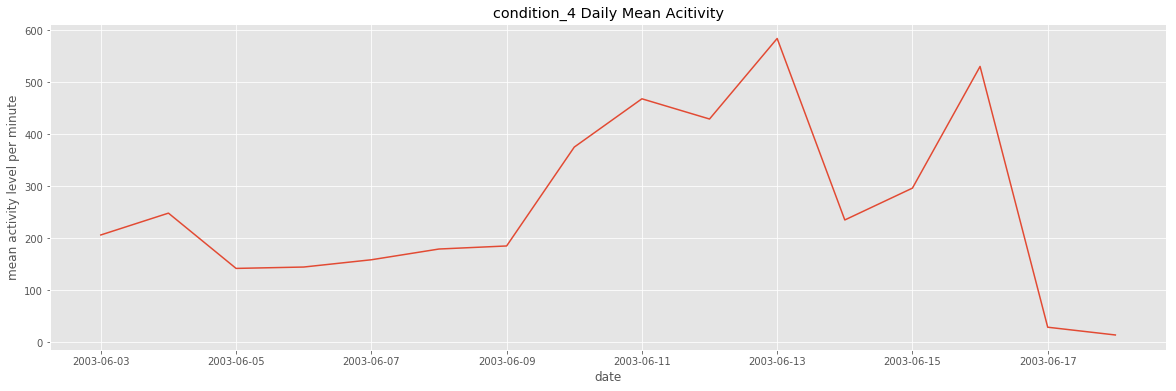

In [33]:
plot_multiday_activity('condition_4')

In [113]:
condition_subjects = [s for s in subjects if s.label == 'condition']
control_subjects = [s for s in subjects if s.label == 'control']
assert len(condition_subjects) == 23 
assert len(control_subjects) == 32

In [382]:
def comparison(mode):
    if mode == 'max-minute':
        # max activity level of each individual, compare between groups
        condition_max = [max(s.motor_data_df['activity']) for s in condition_subjects]
        control_max = [max(s.motor_data_df['activity']) for s in control_subjects]    
        print("Mean max of condition group: {:.2f}".format(np.mean(condition_max)))
        print("Mean max of control group:   {:.2f}".format(np.mean(control_max)))
        plt.figure(figsize=(8,6))
        plt.hist(condition_max, bins=20, alpha=0.5, label='condition')
        plt.hist(control_max, bins=20, alpha=0.5, label='control')
        plt.legend(loc='upper left')
        plt.title('Minute Max Activity Distribution')
    elif mode == 'min-minute':
        # min activity level of each individual, compare between groups
        condition_min = [min(s.motor_data_df['activity']) for s in condition_subjects]
        control_min = [min(s.motor_data_df['activity']) for s in control_subjects]    
        print("Mean min of condition group: {:.2f}".format(np.mean(condition_min)))
        print("Mean min of control group:   {:.2f}".format(np.mean(control_min)))
        plt.figure(figsize=(8,6))
        plt.hist(condition_min, bins=10, alpha=0.5, label='condition')
        plt.hist(control_min, bins=10, alpha=0.5, label='control')
        plt.legend(loc='upper right')
        plt.title('Minute Min Activity Distribution')
    elif mode == 'mean-hour':
        # mean activity level for each hour, compare between groups
        condition_dfs = [s.motor_data_df for s in condition_subjects]
        control_dfs = [s.motor_data_df for s in control_subjects]
        condition_df = pd.concat(condition_dfs, axis=0)
        control_df = pd.concat(control_dfs, axis=0)
        condition_df = condition_df.rename(columns={'activity':'condition activity'})
        control_df = control_df.rename(columns={'activity':'control activity'})
        condition_df['hour'] = condition_df['timestamp'].apply(lambda x : x[:2])
        control_df['hour'] = control_df['timestamp'].apply(lambda x : x[:2])
        condition_mean = condition_df.groupby('hour')['condition activity'].mean() # default ignore nan
        control_mean = control_df.groupby('hour')['control activity'].mean()
        plot_df = pd.concat([condition_mean, control_mean], axis=1)
        plot_df.plot(kind='bar', color=['coral', 'mediumseagreen'], alpha=0.7, figsize=(20,6), title='Mean Activity per Hour Comparison between Two Groups')
    elif mode == 'percentage no activity':
        # percentage of no activity by minute 
        condition_dfs = []
        control_dfs = []
        for s1, s2 in zip(condition_subjects, control_subjects):
            condition_dfs.extend(list(s1.motor_data_days.values()))
            control_dfs.extend(list(s2.motor_data_days.values()))
        condition_count = list(map(get_percentage, condition_dfs))
        control_count = list(map(get_percentage, control_dfs))
        plot_df = pd.DataFrame({'condition': pd.Series(condition_count), 'control': pd.Series(control_count)})
        # comparison box plot
        print(plot_df.describe())
        plot_df.plot(kind='box', figsize=(8,8), 
                     title='No Activity Percentage Boxplots for Condition and Control')
    elif mode == 'bedtime':
        # distribution of bedtime
        #TODO: compute bedtime
        pass
        
def add_hour_col(df):
    df['hour'] = df['timestamp'].apply(lambda x : x[:2])
    
    
def get_percentage(df):
    return sum(df['activity'] == 0) / len(df)

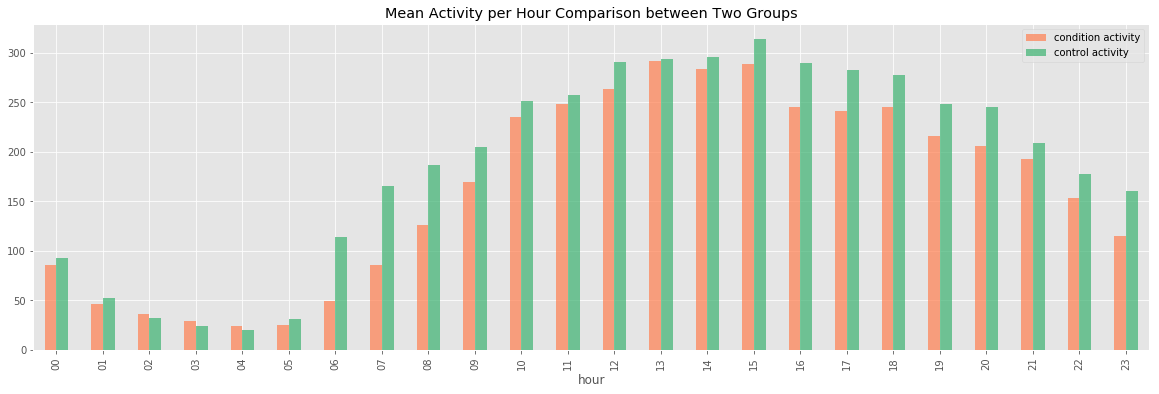

In [383]:
comparison('mean-hour')

        condition     control
count  405.000000  542.000000
mean     0.435628    0.388441
std      0.250433    0.298524
min      0.000000    0.000000
25%      0.324306    0.233681
50%      0.409028    0.328472
75%      0.568750    0.447396
max      1.000000    1.000000


/Users/phichitchulanont/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


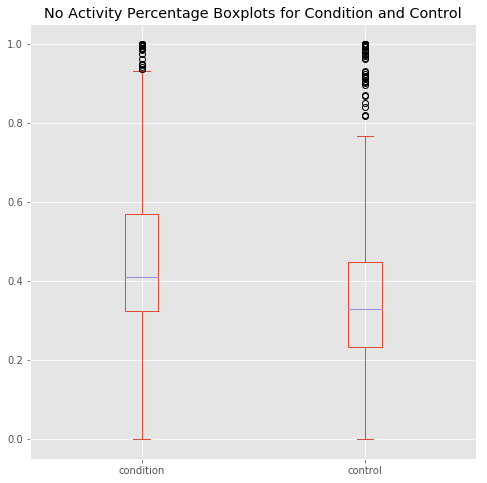

In [366]:
comparison('percentage no activity')

In [264]:
def compare_by_hour(subject_1, subject_2):
    subject_1_df = subjects_dict[subject_1].motor_data_df
    subject_2_df = subjects_dict[subject_2].motor_data_df
    subject_1_df = subject_1_df.rename(columns={'activity':'{} activity'.format(subject_1)})
    subject_2_df = subject_2_df.rename(columns={'activity':'{} activity'.format(subject_2)})
    subject_1_df['hour'] = subject_1_df['timestamp'].apply(lambda x : x[:2])
    subject_2_df['hour'] = subject_2_df['timestamp'].apply(lambda x : x[:2])
    s1_hour_mean = subject_1_df.groupby('hour')['{} activity'.format(subject_1)].mean() 
    s2_hour_mean = subject_2_df.groupby('hour')['{} activity'.format(subject_2)].mean()
    plot_df = pd.concat([s1_hour_mean, s2_hour_mean], axis=1)
    plot_df.plot(kind='bar', color=['coral', 'mediumseagreen'], alpha=0.7, figsize=(20,6), title='Mean Activity per Hour Comparison between Two Subjects')
    

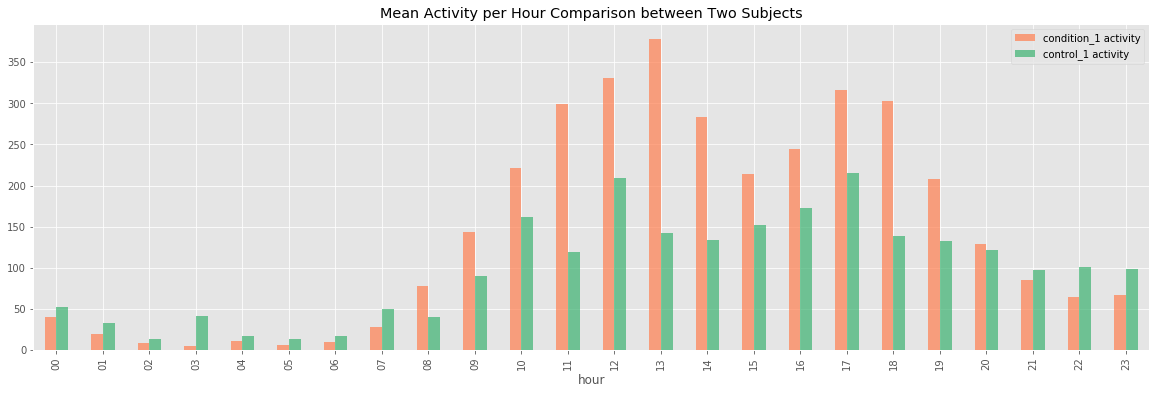

In [273]:
compare_by_hour('condition_1', 'control_1')